# ML Project : chord embedding

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load the data
When loading the key dataset, we can choose whether to drop one-word sentences.  
When loading the chord dataset, we can choose whether to keep sections in major or minor key, or both.

In [45]:
from load_data import load_chord_data, load_key_data, all_composers

In [106]:
# Optional parameter for load_key_data: drop_one_worders = True/False
bach_key = load_key_data(all_composers)

# Optional parameter for load_chord_data: key_mode = 'both'/'major'/'minor'
bach_chord_both = load_chord_data(all_composers, key_mode='minor')

## Apply Word2Vec

In [107]:
from gensim.models import Word2Vec

In [108]:
# Ignore words with a lower frequency frequency than this
min_count = 10
# Size of the embedding space
size = 20 
# Neighborhood of the focus word to study
window = 2
# 0 for CBOW, 1 for skip-gram
sg = 0 

# The first argument has to be a list of lists of words
model_bach_both = Word2Vec(bach_chord_both, min_count=min_count, size=size, window=window, sg=sg)

## Reduce dimensionality and visualise

### Reduce dimensionality: PCA

In [109]:
from sklearn.decomposition import PCA
from reduce_dim import reduce_dim_keyed_vec

In [110]:
pca = PCA(n_components=2)
wv_red = reduce_dim_keyed_vec(model_bach_both.wv, pca.fit_transform)

### Visualise

In [111]:
from visual import visual_reduced_chord_vectors

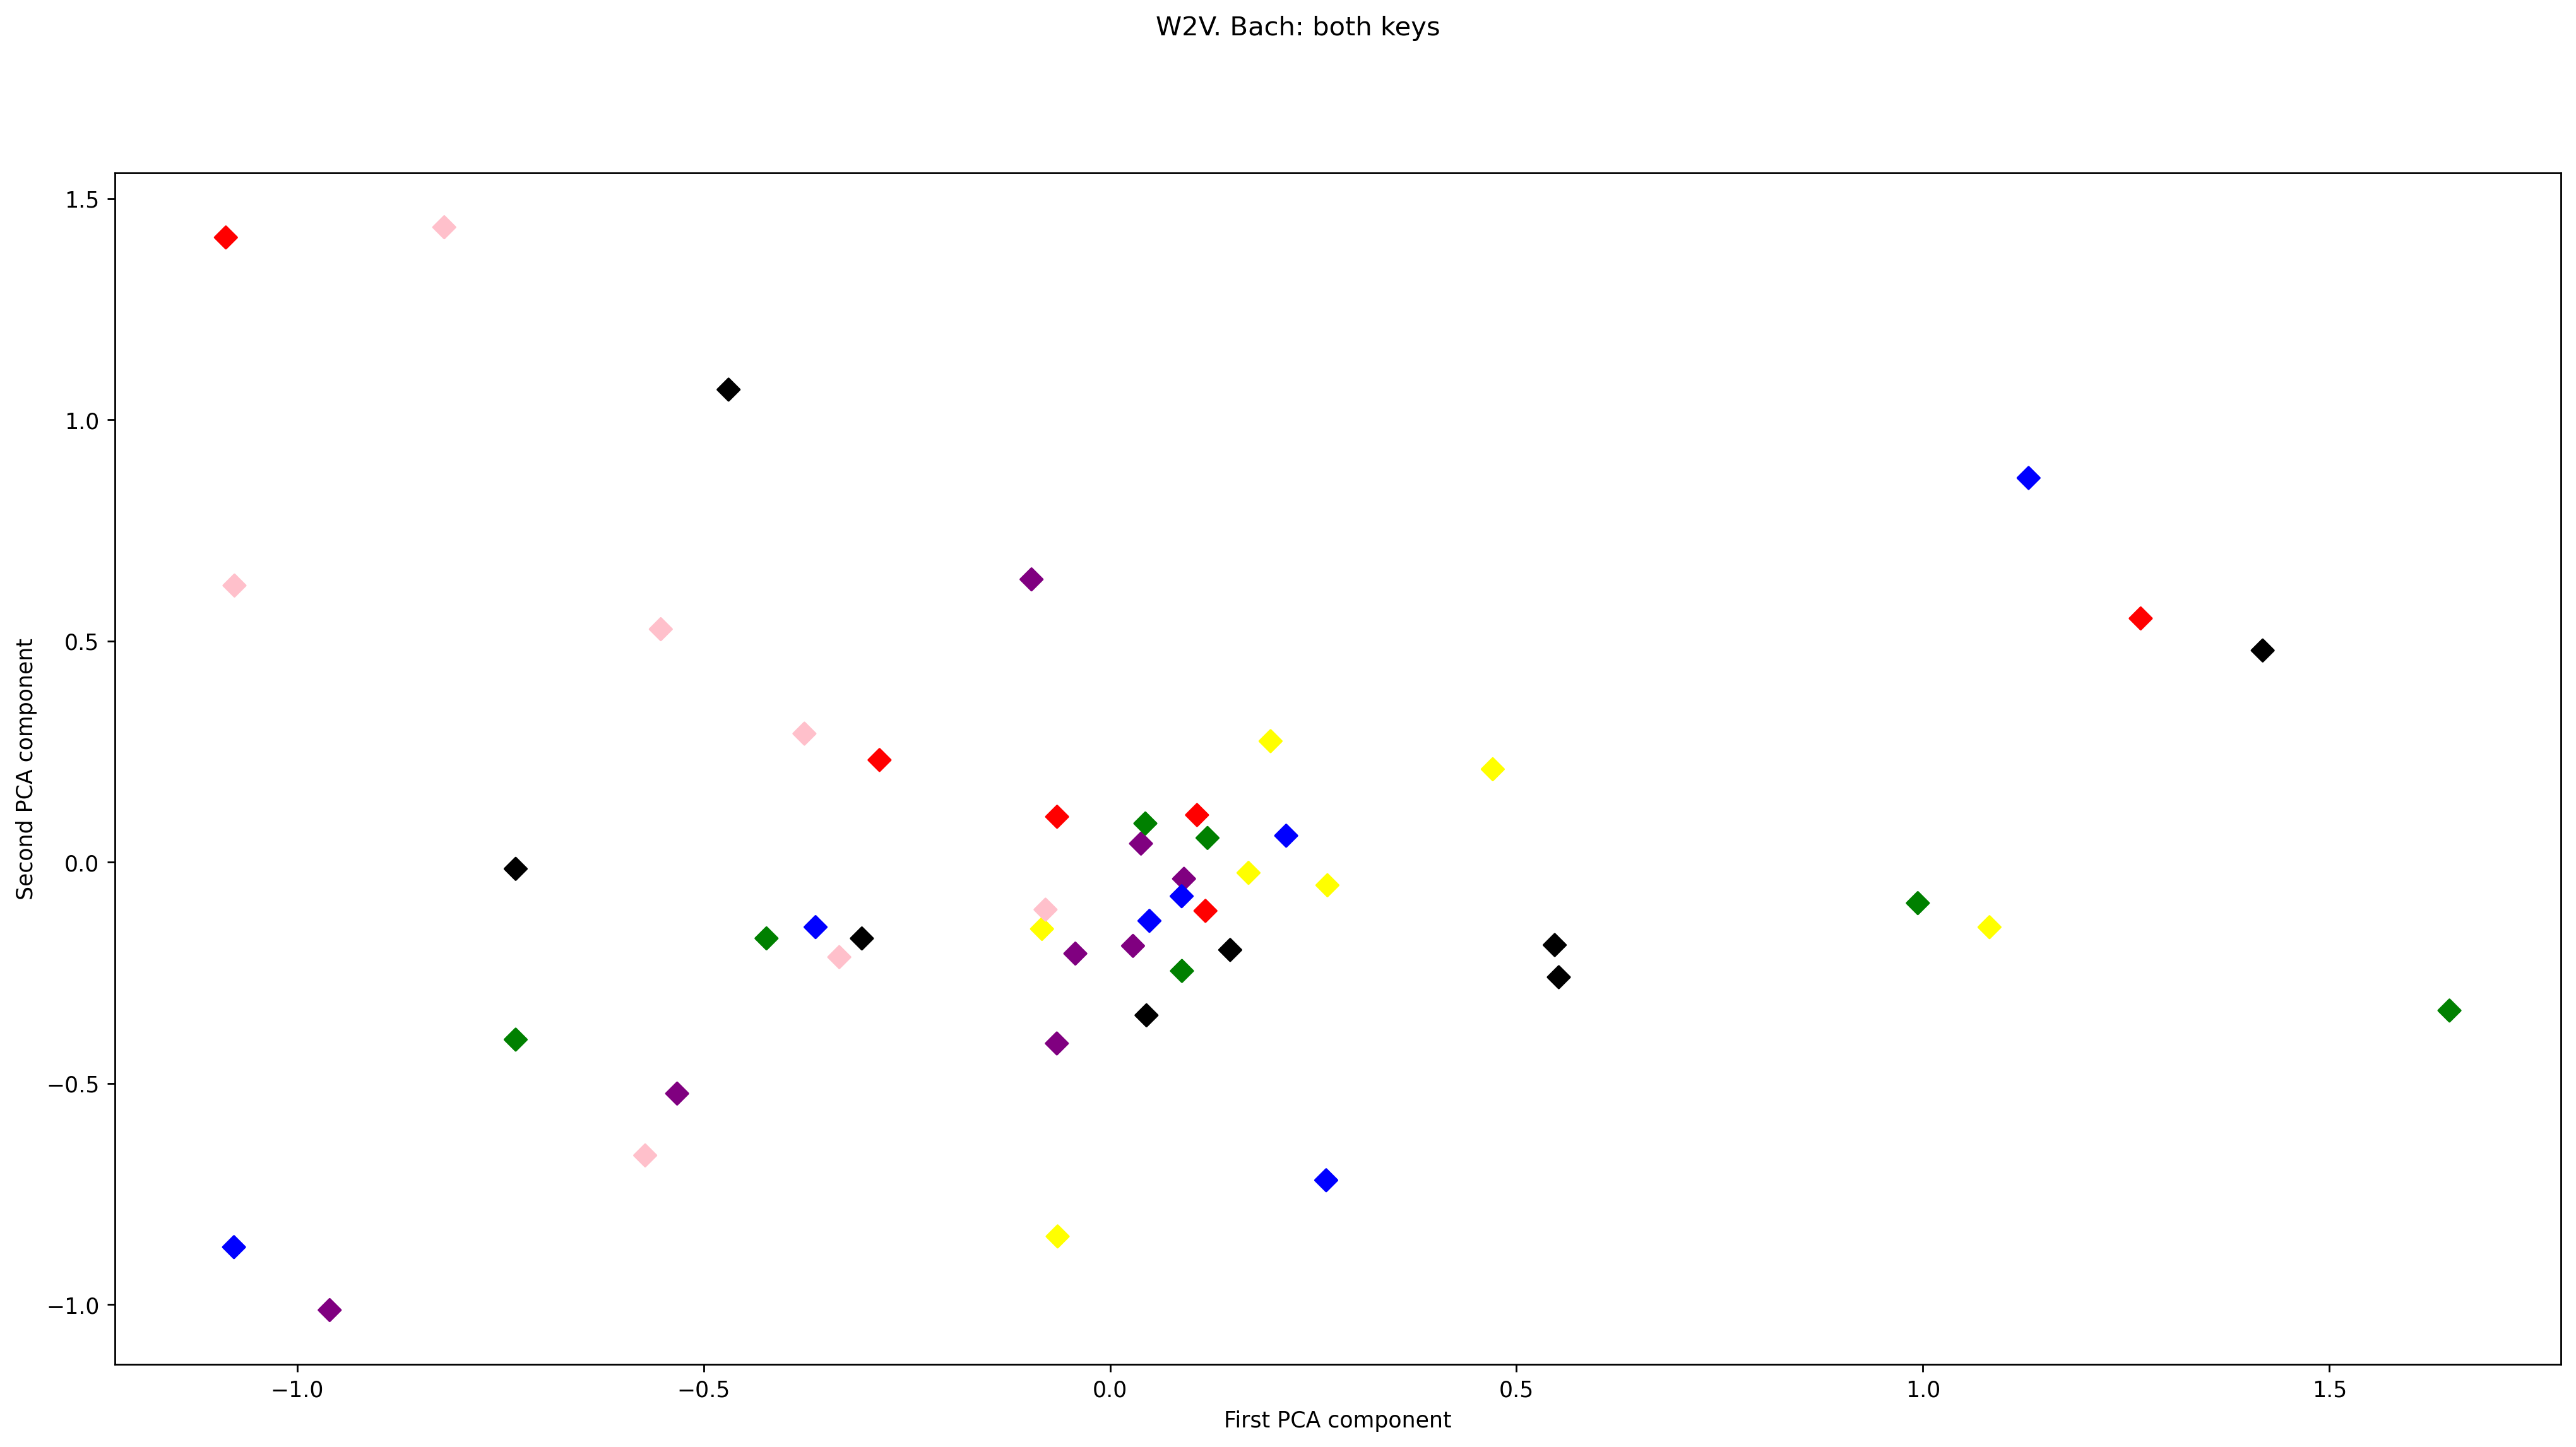

In [112]:
visual_reduced_chord_vectors(wv_red, dimred_method='PCA', plot_title='W2V. Bach: both keys')

## Investigate similarities

In [122]:
model_bach_both.wv.similarity('I:MAJ', 'V:MAJ')

0.40067127

In [124]:
model_bach_both.wv.most_similar('I:MIN', topn = 100)

[('V:MAJ', 0.9474716186523438),
 ('II:DIM', 0.944913387298584),
 ('#IV:MAJ', 0.7997113466262817),
 ('IV:MIN', 0.7702906131744385),
 ('#VII:DIM', 0.7639704942703247),
 ('##IV:DIM', 0.759774386882782),
 ('VII:DIM', 0.7217479944229126),
 ('#IV:DIM', 0.7021120190620422),
 ('#VII:MIN', 0.6964181661605835),
 ('VI:MAJ', 0.6865967512130737),
 ('#I:MAJ', 0.6829463839530945),
 ('#IV:MIN', 0.6769144535064697),
 ('bVII:MAJ', 0.6580970287322998),
 ('III:DIM', 0.6552954912185669),
 ('bII:MIN', 0.6443495154380798),
 ('#II:DIM', 0.6373398303985596),
 ('III:AUG', 0.6311668157577515),
 ('VI:DIM', 0.6280919909477234),
 ('#V:DIM', 0.6166166067123413),
 ('VI:AUG', 0.6161235570907593),
 ('bII:DIM', 0.6140212416648865),
 ('#VII:MAJ', 0.6128526926040649),
 ('#III:MIN', 0.6113572120666504),
 ('#III:MAJ', 0.6107150316238403),
 ('bI:AUG', 0.5963138341903687),
 ('V:AUG', 0.5937913656234741),
 ('bI:MAJ', 0.5888795256614685),
 ('bIV:MAJ', 0.5509770512580872),
 ('IV:DIM', 0.5339253544807434),
 ('#I:DIM', 0.527732849